<a href="https://colab.research.google.com/github/radrams/child_malnutrition/blob/master/Stunting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import random
import warnings
from math import nan

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import xgboost
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from xgboost import XGBClassifier
import os
import statsmodels.api as sm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

np.random.seed(42)
random.seed(42)
warnings.filterwarnings('ignore')

path = 'https://github.com/radrams/child_malnutrition/raw/master/data/stunting.xlsx'

############## Read from Excel file ######################################################
# Read the data
df_immu_hyg_stunting = pd.read_excel(path, sheet_name='stunting')
# Print Column names
print(df_immu_hyg_stunting.head())
print('===============================================================')
# print(df_immu_hyg_stunting.columns.ravel())
print(df_immu_hyg_stunting.describe())
print('===============================================================')
print(df_immu_hyg_stunting.isnull().sum())
print('===============================================================')

   SH.H2O.BASW.ZS  SH.IMM.HEPB  SH.IMM.HIB3  SH.IMM.IBCG  SH.IMM.IDPT  SH.IMM.MEAS  SH.IMM.POL3  SH.STA.ARIC.ZS  SH.STA.BASS.ZS  SH.STA.HYGN.ZS  SH.STA.ORCF.ZS  SH.STA.ORTH  SH.STA.STNT.ZS
0       52.347633          NaN          NaN         81.0         59.0         65.0         62.0            37.0        9.963399             NaN            59.2         17.8            49.0
1       59.891152          NaN          NaN         87.0         82.0         79.0         82.0            54.3       23.394743             NaN            49.9          NaN            42.8
2       64.416401         91.0          NaN         98.0         91.0         89.0         91.0             NaN       31.831055       65.243300             NaN          NaN            39.5
3       67.551234         91.0         86.0         95.0         90.0         90.0         90.0             NaN       37.820551       65.322480            48.0          NaN            39.8
4       73.816151         91.0         91.0         98.

In [51]:
############ Drop Columns having 'na' count greater than 150 rows =================
max_number_of_nas = 150
df_immu_hyg_stunting = df_immu_hyg_stunting.loc[:, (df_immu_hyg_stunting.isnull().sum(axis=0) <= max_number_of_nas)]
############################################### MISSING VALUES #############6############################################
# Number of missing values
print('===================== Missing Values Summary Before Imputation=====================')
print(df_immu_hyg_stunting.isnull().sum())
print('===============================================================')

############################################### Handling missing values using mean imputation
df_immu_hyg_stunting.fillna(df_immu_hyg_stunting.mean(), inplace=True)
print('===================== Missing Values Summary After Imputation=====================')
print(df_immu_hyg_stunting.isnull().sum())
print('===============================================================')

===================== Missing Values Summary Before Imputation=====================
SH.H2O.BASW.ZS     29
SH.IMM.HEPB        72
SH.IMM.HIB3       144
SH.IMM.IBCG        12
SH.IMM.IDPT        12
SH.IMM.MEAS        12
SH.IMM.POL3        12
SH.STA.BASS.ZS     30
SH.STA.STNT.ZS      0
dtype: int64
===================== Missing Values Summary After Imputation=====================
SH.H2O.BASW.ZS    0
SH.IMM.HEPB       0
SH.IMM.HIB3       0
SH.IMM.IBCG       0
SH.IMM.IDPT       0
SH.IMM.MEAS       0
SH.IMM.POL3       0
SH.STA.BASS.ZS    0
SH.STA.STNT.ZS    0
dtype: int64


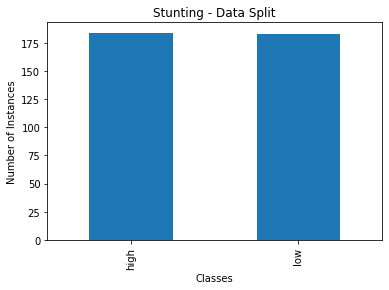

In [52]:
########################################### Defining input and output columns
X = df_immu_hyg_stunting.loc[:, df_immu_hyg_stunting.columns != 'SH.STA.STNT.ZS']

################# Grouping Data
median_split = df_immu_hyg_stunting['SH.STA.STNT.ZS'].median()
y = pd.cut(df_immu_hyg_stunting['SH.STA.STNT.ZS'], bins=[0, median_split, 100], right=False, labels=['low', 'high'])
y.value_counts().plot(kind='bar')
plt.title("Stunting - Data Split")
plt.xlabel('Classes')
plt.ylabel('Number of Instances')
plt.show()
###################################################################################################

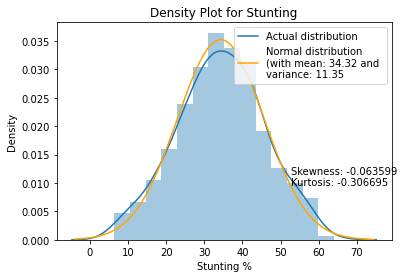

In [53]:
############################################## Distribution plot
f, ax = plt.subplots(1, sharex=True)
mean_value = df_immu_hyg_stunting['SH.STA.STNT.ZS'].mean()
std_value = df_immu_hyg_stunting['SH.STA.STNT.ZS'].std()
sns.distplot(df_immu_hyg_stunting['SH.STA.STNT.ZS'], kde_kws={"label": "Actual distribution"},
             fit=stats.norm, fit_kws={"label": "Normal distribution\n(with mean: {:0.2f} and \nvariance: {:0.2f}"
                                               .format(mean_value, std_value), "color":"orange"})
plt.title('Density Plot for Stunting')
plt.xlabel('Stunting %')
plt.ylabel('Density')
plt.legend(loc="upper right")
f.text(x=0.7, y=0.3,  transform = ax.transAxes, s="Skewness: {:0.6f}".format(df_immu_hyg_stunting['SH.STA.STNT.ZS'].skew()))
f.text(x=0.7, y=0.25, transform = ax.transAxes, s="Kurtosis: {:0.6f}".format(df_immu_hyg_stunting['SH.STA.STNT.ZS'].kurt()))
plt.show()

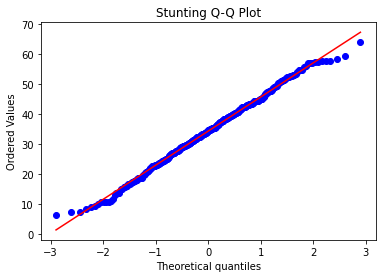

In [54]:
############ Q-Q Plot
stats.probplot(df_immu_hyg_stunting['SH.STA.STNT.ZS'], dist="norm", plot=plt)
plt.title("Stunting Q-Q Plot")
plt.show()

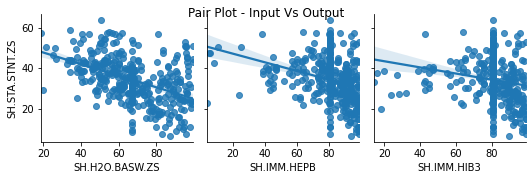

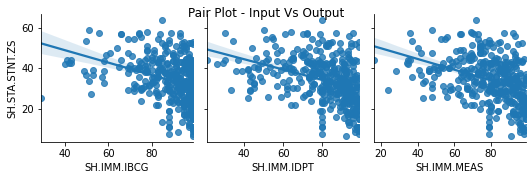

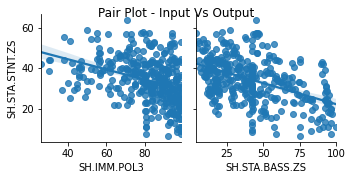

In [55]:
########### Pairplot
g = sns.pairplot(df_immu_hyg_stunting, x_vars=X.columns[0:3], y_vars='SH.STA.STNT.ZS', kind="reg")
g.fig.suptitle("Pair Plot - Input Vs Output")
plt.tight_layout()
plt.show()
g = sns.pairplot(df_immu_hyg_stunting, x_vars=X.columns[3:6], y_vars='SH.STA.STNT.ZS', kind="reg")
g.fig.suptitle("Pair Plot - Input Vs Output")
plt.tight_layout()
plt.show()
g = sns.pairplot(df_immu_hyg_stunting, x_vars=X.columns[6:9], y_vars='SH.STA.STNT.ZS', kind="reg")
g.fig.suptitle("Pair Plot - Input Vs Output")
plt.tight_layout()
plt.show()

SH.STA.STNT.ZS    1.000000
SH.IMM.HIB3      -0.191341
SH.IMM.HEPB      -0.313387
SH.IMM.IBCG      -0.346550
SH.IMM.POL3      -0.355395
SH.IMM.IDPT      -0.377236
SH.IMM.MEAS      -0.384580
SH.H2O.BASW.ZS   -0.461405
SH.STA.BASS.ZS   -0.463802
Name: SH.STA.STNT.ZS, dtype: float64


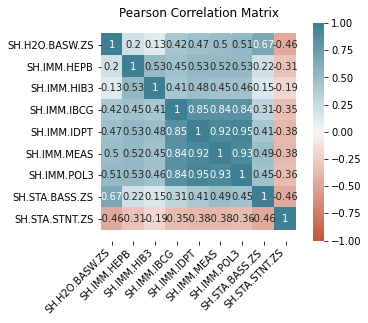

Removed Correlated Columns: {'SH.IMM.MEAS', 'SH.IMM.POL3', 'SH.IMM.IDPT'}


In [56]:
######################## Remove correlated Features
correlated_features = set()
corr = df_immu_hyg_stunting.corr()
print(corr['SH.STA.STNT.ZS'].sort_values(ascending=False))
print('===============================================================')
ax = sns.heatmap(
    corr,
    annot=True,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.title('Pearson Correlation Matrix')
# plt.tight_layout()
plt.show()

for i in range(len(corr .columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.8:
            colname = corr.columns[i]
            correlated_features.add(colname)
print('Removed Correlated Columns:', correlated_features)
print('===============================================================')
X.drop(labels=correlated_features, axis=1, inplace=True)

Average accuracy of LogisticRegression is 0.6587087087087087
[0.75675676 0.67567568 0.48648649 0.67567568 0.97297297 0.59459459
 0.7027027  0.5        0.61111111 0.61111111]
Accuracy of the current fold:  0.659400544959128
Average accuracy of GaussianNB is 0.6754504504504505
[0.7027027  0.67567568 0.54054054 0.67567568 0.91891892 0.62162162
 0.7027027  0.52777778 0.72222222 0.66666667]
Accuracy of the current fold:  0.6757493188010899
Average accuracy of KNeighborsClassifier is 0.6862612612612613
[0.7027027  0.64864865 0.59459459 0.72972973 0.86486486 0.62162162
 0.78378378 0.58333333 0.69444444 0.63888889]
Accuracy of the current fold:  0.6866485013623979
Average accuracy of XGBClassifier is 0.7296546546546546
[0.83783784 0.72972973 0.72972973 0.83783784 0.94594595 0.51351351
 0.72972973 0.55555556 0.77777778 0.63888889]
Accuracy of the current fold:  0.7302452316076294
Average accuracy of DecisionTreeClassifier is 0.708033033033033
[0.75675676 0.78378378 0.7027027  0.78378378 0.78378

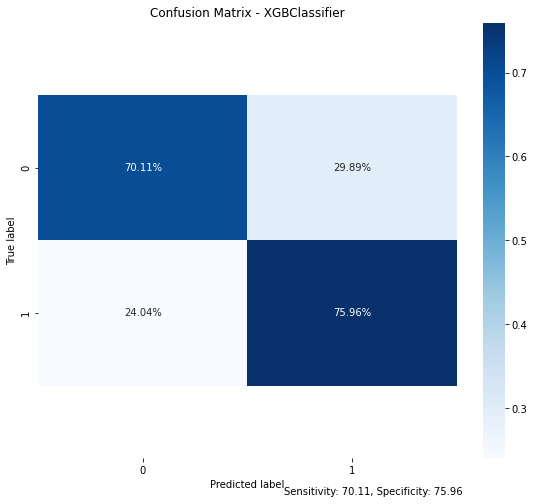

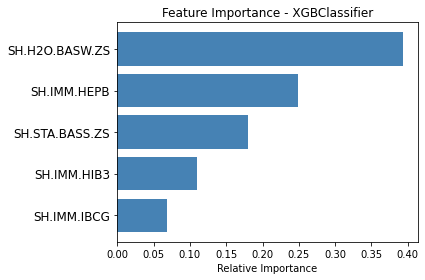

              precision    recall  f1-score   support

        high       0.75      0.70      0.72       184
         low       0.72      0.76      0.74       183

    accuracy                           0.73       367
   macro avg       0.73      0.73      0.73       367
weighted avg       0.73      0.73      0.73       367

Confusion matrix for  SVC :  [[138  46]
 [ 59 124]]
Sensitivity :  75.0
Specificity :  67.75956284153006


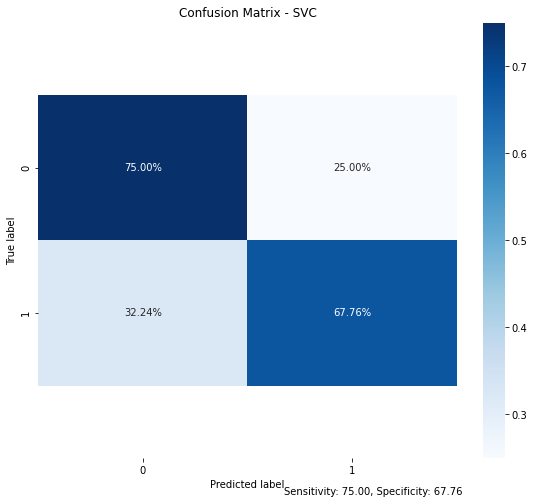

              precision    recall  f1-score   support

        high       0.70      0.75      0.72       184
         low       0.73      0.68      0.70       183

    accuracy                           0.71       367
   macro avg       0.71      0.71      0.71       367
weighted avg       0.71      0.71      0.71       367

Confusion matrix for  RandomForestClassifier :  [[135  49]
 [ 57 126]]
Sensitivity :  73.36956521739131
Specificity :  68.85245901639344


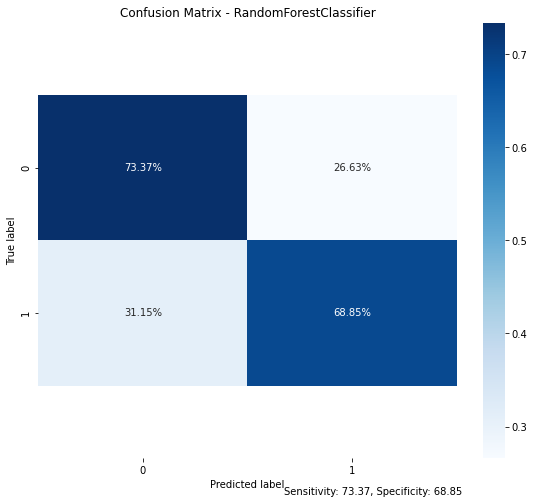

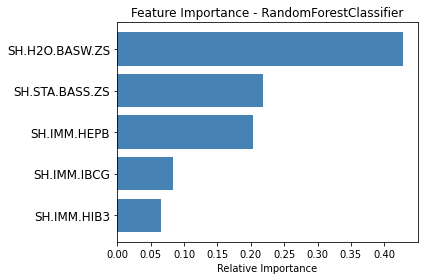

              precision    recall  f1-score   support

        high       0.70      0.73      0.72       184
         low       0.72      0.69      0.70       183

    accuracy                           0.71       367
   macro avg       0.71      0.71      0.71       367
weighted avg       0.71      0.71      0.71       367



In [57]:
########################################################################################################################################
##################### MODELS ######################
classifiers =[]
clf_logit = LogisticRegression()
classifiers.append(clf_logit)
clf_nb = GaussianNB()
classifiers.append(clf_nb)
clf_knn = KNeighborsClassifier(n_neighbors=13)
classifiers.append(clf_knn)

clf_accuracies = {}
############## Fine-tune XGB #################
# estimator = xgboost.XGBClassifier(
#     nthread=4,
#     seed=42
# )
# parameters = {
#     'max_depth': range (2, 10, 1),
#     'n_estimators': range(60, 220, 40),
#     'learning_rate': [0.1, 0.01, 0.05],
# }

# grid_search = GridSearchCV(
#     estimator=estimator,
#     param_grid=parameters,
#     n_jobs = 10,
#     cv = 10,
#     verbose=True
# )
# grid_search.fit(X, y)
# print(grid_search.best_estimator_)
# classifiers.append(grid_search.best_estimator_)

################# XGB classifier with fine-tuned parameters
# classifiers.append(xgboost.XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
#               importance_type='gain', interaction_constraints=None,
#               learning_rate=0.01, max_delta_step=0, max_depth=4,
#               min_child_weight=1, missing=nan, monotone_constraints=None,
#               n_estimators=140, n_jobs=4, nthread=4, num_parallel_tree=1,
#               objective='binary:logistic', random_state=42, reg_alpha=0,
#               reg_lambda=1, scale_pos_weight=1, seed=42, subsample=1,
#               tree_method='auto', validate_parameters=False))

classifiers.append(xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=140, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1))

# # ################################## Fine-tune Decision Tree
# # Define the parameter values that should be searched
# criterion = ['gini', 'entropy']
# max_depth = [4, 6, 8, 12]
# parameters = dict(criterion=criterion, max_depth=max_depth)
#
# # instantiate the grid
# dtc = DecisionTreeClassifier(random_state=0)
# grid = GridSearchCV(dtc, parameters, cv=10, scoring='accuracy')
#
# # fit the grid with data
# grid.fit(X, y)
# print(grid.best_estimator_)
# classifiers.append(grid.best_estimator_)

################# Decision Tree classifier with fine-tuned parameters
classifiers.append((DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')))

# ############################################### Fine-Tune SVC
# # define model and parameters
# model_svc = sklearn.svm.SVC()
# kernel = ['poly', 'rbf', 'sigmoid']
# C = [50, 10, 1.0, 0.1, 0.01]
# gamma = ['scale']
# # define grid search
# grid = dict(kernel=kernel,C=C,gamma=gamma)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search_svc = GridSearchCV(estimator=model_svc, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result_svc = grid_search_svc.fit(X, y)
# print(grid_search_svc.best_estimator_)
# classifiers.append(grid_search_svc.best_estimator_)

################# SVC classifier with fine-tuned parameters
classifiers.append(sklearn.svm.SVC(C=50, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False))

# # ############################################### Fine-Tune Random Forest
# model = RandomForestClassifier()
# n_estimators = [100, 300, 500, 800, 1200]
# max_depth = [5, 8, 15, 25, 30]
# min_samples_split = [2, 5, 10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10]
#
# hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,
#               min_samples_split = min_samples_split,
#              min_samples_leaf = min_samples_leaf)
#
# gridF = GridSearchCV(model, hyperF, cv = 3, verbose = 1, n_jobs = -1)
# bestF = gridF.fit(X, y)
# print(gridF.best_estimator_)
# classifiers.append(gridF.best_estimator_)

################# Random Forest classifier with fine-tuned parameters
classifiers.append(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False))

# ############### Function to plot confusion matrix
def plot_cm(model_name, df_cm):
    # df_cm = confusion_matrix(dtree_predictions, y_test, labels=['high', 'low'])
    plt.figure(figsize = (8,7))
    sns.heatmap(df_cm/ df_cm.sum(axis=1)[:, np.newaxis], annot=True,fmt='.2%', cmap='Blues')
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) * 100
    print('Sensitivity : ', sensitivity)
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1]) * 100
    print('Specificity : ', specificity)
    plt.title('Confusion Matrix - ' + model_name)
    plt.figtext(0.5, 0.01, 'Sensitivity: {:.2f}, Specificity: {:.2f}'.format(sensitivity, specificity))
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

# ######### Plot Feature Importance
def plot_feature_importance(model):
    try:
        model.fit(X, y)
        importance = model.feature_importances_
        features = X.columns
        indices = np.argsort(importance)
        plt.title('Feature Importance - ' + model.__class__.__name__)
        plt.barh(range(len(indices)), importance[indices], color='steelblue', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize=12)
        plt.xlabel('Relative Importance')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        pass

#############################################################
# Calculate cross-validation scores
for clf in classifiers:
    all_accuracies = cross_val_score(estimator=clf, X=X, y=y, cv=10)
    print("Average accuracy of %s is %s"%(clf.__class__.__name__, all_accuracies.mean()))
    print(all_accuracies)
    y_pred = cross_val_predict(clf, X, y, cv=10)
    accuracy = accuracy_score(y, y_pred)
    print('Accuracy of the current fold: ', accuracy )
    clf_accuracies[clf.__class__.__name__] = accuracy
    print('===============================================================')

# print the sorted classifier accuracies
sorted_accuracies = sorted(clf_accuracies.items(), key=lambda item: item[1], reverse=True)
print('Sorted Accuracies:')
print('===============================================================')
for k, v in sorted(clf_accuracies.items(), key=lambda item: item[1], reverse=True):
    print(k, " ", v)

print('===============================================================')
top_3_accuracies = dict(sorted_accuracies[:3])

#### Calculate Confusion matrix and Feature Importance for Top 3 classifiers
for clf in classifiers:
    if clf.__class__.__name__ in top_3_accuracies.keys():
        y_pred = cross_val_predict(clf, X, y, cv=10)
        cm = confusion_matrix(y, y_pred)
        print('Confusion matrix for ', clf.__class__.__name__ , ': ', cm)
        plot_cm(clf.__class__.__name__, cm)
        plot_feature_importance(clf)
        print(classification_report(y, y_pred))
        print('===============================================================')

Area under the ROC curve for SVC: 0.711051
Area under the ROC curve for Random Forest: 0.742887
Area under the ROC curve for XGB Classifier: 0.757588


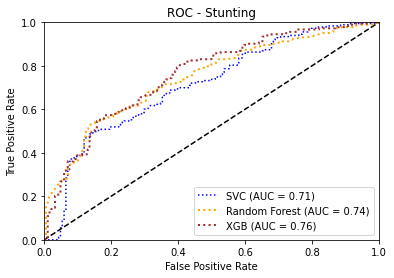

In [58]:
# #################### Compute ROC curve and area the curve
## ROC Curve for SVC
probas_ = cross_val_predict(sklearn.svm.SVC(probability=True), X, y, cv=10, method="predict_proba")
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y, probas_[:, 1], pos_label='low')
roc_auc_svc = auc(fpr_svc, tpr_svc)
print("Area under the ROC curve for SVC: %f" % roc_auc_svc)

# Plot ROC curve
plt.clf()
plt.plot(fpr_svc, tpr_svc, "b:", label='SVC (AUC = %0.2f)' % roc_auc_svc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Stunting')
plt.legend(loc="lower right")

# ### ROC Curve Random Forest
y_prob_pred = cross_val_predict(RandomForestClassifier(random_state=0), X, y, cv=10, method="predict_proba")
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y, y_prob_pred[:, 1], pos_label='low')
roc_auc_rf = auc(fpr_rf, tpr_rf)
print("Area under the ROC curve for Random Forest: %f" % roc_auc_rf)
plt.plot(fpr_rf, tpr_rf, linestyle=':', color='orange', linewidth=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.legend(loc="lower right")

# ######### ROC Curve Decision Tree
# y_prob_pred = cross_val_predict(DecisionTreeClassifier(random_state=0), X, y, cv=10, method="predict_proba")
# fpr_dt, tpr_dt, thresholds_dt = roc_curve(y, y_prob_pred[:, 1], pos_label='low')
# roc_auc_dt = auc(fpr_dt, tpr_dt)
# print("Area under the ROC curve for Decision Tree: %f" % roc_auc_dt)
# plt.plot(fpr_dt, tpr_dt, linestyle=':', color='green', linewidth=2, label='Decision Tree (area = %0.2f)' % roc_auc_dt)
# plt.legend(loc="lower right")

# ################ ROC Curve XGB
y_prob_pred = cross_val_predict(XGBClassifier(random_state=0), X, y, cv=10, method="predict_proba")
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y, y_prob_pred[:, 1], pos_label='low')
roc_auc_knn = auc(fpr_knn, tpr_knn)
print("Area under the ROC curve for XGB Classifier: %f" % roc_auc_knn)
plt.plot(fpr_knn, tpr_knn, linestyle=':', color='brown', linewidth=2, label='XGB (AUC = %0.2f)' % roc_auc_knn)
plt.legend(loc="lower right")
plt.show()
# ##################################